# Wasserstein-based clustering

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.cluster import KMeans
from wkmeans import WKMeans
from MAslope import ma_slope

In [2]:
# Data
df = pd.read_parquet("btc_binance_1d.parquet")
df.head()

Open     High      Low    Close       Volume
Date                                                       
2017-08-17  4261.48  4485.39  4200.74  4285.08   795.150377
2017-08-18  4285.08  4371.52  3938.77  4108.37  1199.888264
2017-08-19  4108.37  4184.69  3850.00  4139.98   381.309763
2017-08-20  4120.98  4211.08  4032.62  4086.29   467.083022
2017-08-21  4069.13  4119.62  3911.79  4016.00   691.743060

In [3]:
# Data
df_features = pd.read_parquet("btc_features.parquet")
df_features.head()

Returns   slope_7  slope_14  slope_21  slope_30
Date                                                        
2017-09-16  0.004032 -1.073904 -1.195123 -0.977491 -0.757684
2017-09-17 -0.004035 -0.911085 -1.097203 -0.930232 -0.737324
2017-09-18  0.086679  1.495757  0.169982 -0.099188 -0.168323
2017-09-19 -0.031461  0.311813 -0.270929 -0.370303 -0.353649
2017-09-20 -0.002571  0.168780 -0.269161 -0.360412 -0.347754

## Number of clusters

======== WK-Means ========
For no of clusters = 2  The average silhouette_score is : 0.4338993020729259
For no of clusters = 3  The average silhouette_score is : 0.39500660201539384
For no of clusters = 4  The average silhouette_score is : 0.3631835637715771
For no of clusters = 5  The average silhouette_score is : 0.3393781490704065
For no of clusters = 6  The average silhouette_score is : 0.29554523324100684


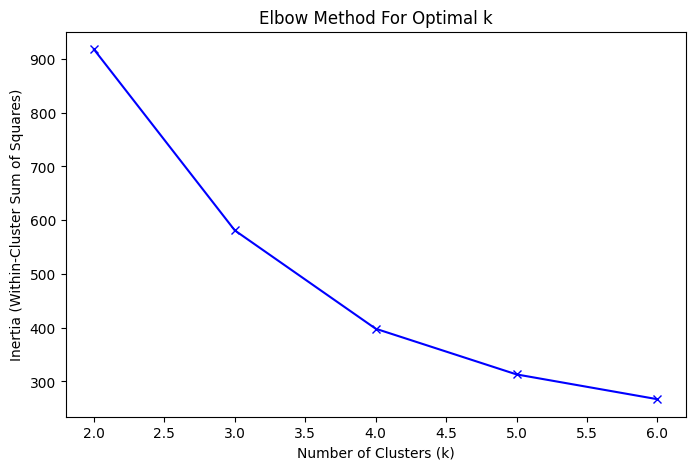

In [4]:
from sklearn.metrics import silhouette_score

# Define dataset
dataset = df_features.values
inertia = []

no_of_clusters = [2, 3, 4, 5, 6]

print('======== WK-Means ========')
for n_clusters in no_of_clusters:

    cluster = WKMeans(k=n_clusters)
    cluster.fit(dataset, inertia=True)
    cluster_labels = cluster.predict(dataset)
    
    inertia.append(cluster.inertia_)
    silhouette_avg = silhouette_score(dataset, cluster_labels)

    print("For no of clusters =", n_clusters,
          " The average silhouette_score is :", silhouette_avg)
    
plt.figure(figsize=(8, 5))
plt.plot(no_of_clusters, inertia, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method For Optimal k')
plt.show()

Try 2, 3, 4 clusters with WK-Means

======== K-Means ========
For no of clusters = 2  The average silhouette_score is : 0.4394641688968798
For no of clusters = 3  The average silhouette_score is : 0.46570170567291325
For no of clusters = 4  The average silhouette_score is : 0.41507449762503995
For no of clusters = 5  The average silhouette_score is : 0.40496263914036335
For no of clusters = 6  The average silhouette_score is : 0.37251710791795867
For no of clusters = 7  The average silhouette_score is : 0.36395061463676087
For no of clusters = 8  The average silhouette_score is : 0.3390629547690167
For no of clusters = 9  The average silhouette_score is : 0.3235467234139404
For no of clusters = 10  The average silhouette_score is : 0.3244717430552893


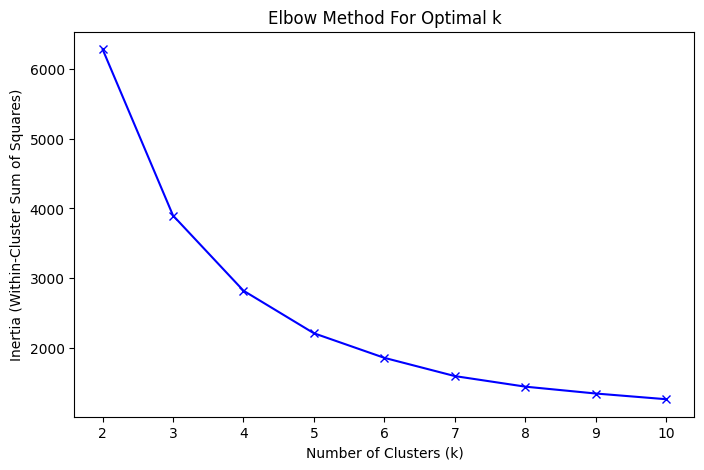

In [5]:
inertia = []
no_of_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
print('======== K-Means ========')
for n_clusters in no_of_clusters:

    cluster = KMeans(n_clusters=n_clusters)
    cluster_labels = cluster.fit_predict(dataset)

    inertia.append(cluster.inertia_)
    silhouette_avg = silhouette_score(dataset, cluster_labels)

    print("For no of clusters =", n_clusters,
          " The average silhouette_score is :", silhouette_avg)
    
plt.figure(figsize=(8, 5))
plt.plot(no_of_clusters, inertia, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method For Optimal k')
plt.show()

Try 2, 3, 4 clusters with K-Means

## K-Means

### 2 clusters

In [27]:
kmeans=KMeans(n_clusters=2, random_state=1)
kmeans.fit(dataset)
df_features['cluster'] = kmeans.predict(dataset).tolist()
df_features['cluster'] = df_features['cluster'].map({0: 1, 1: 0})

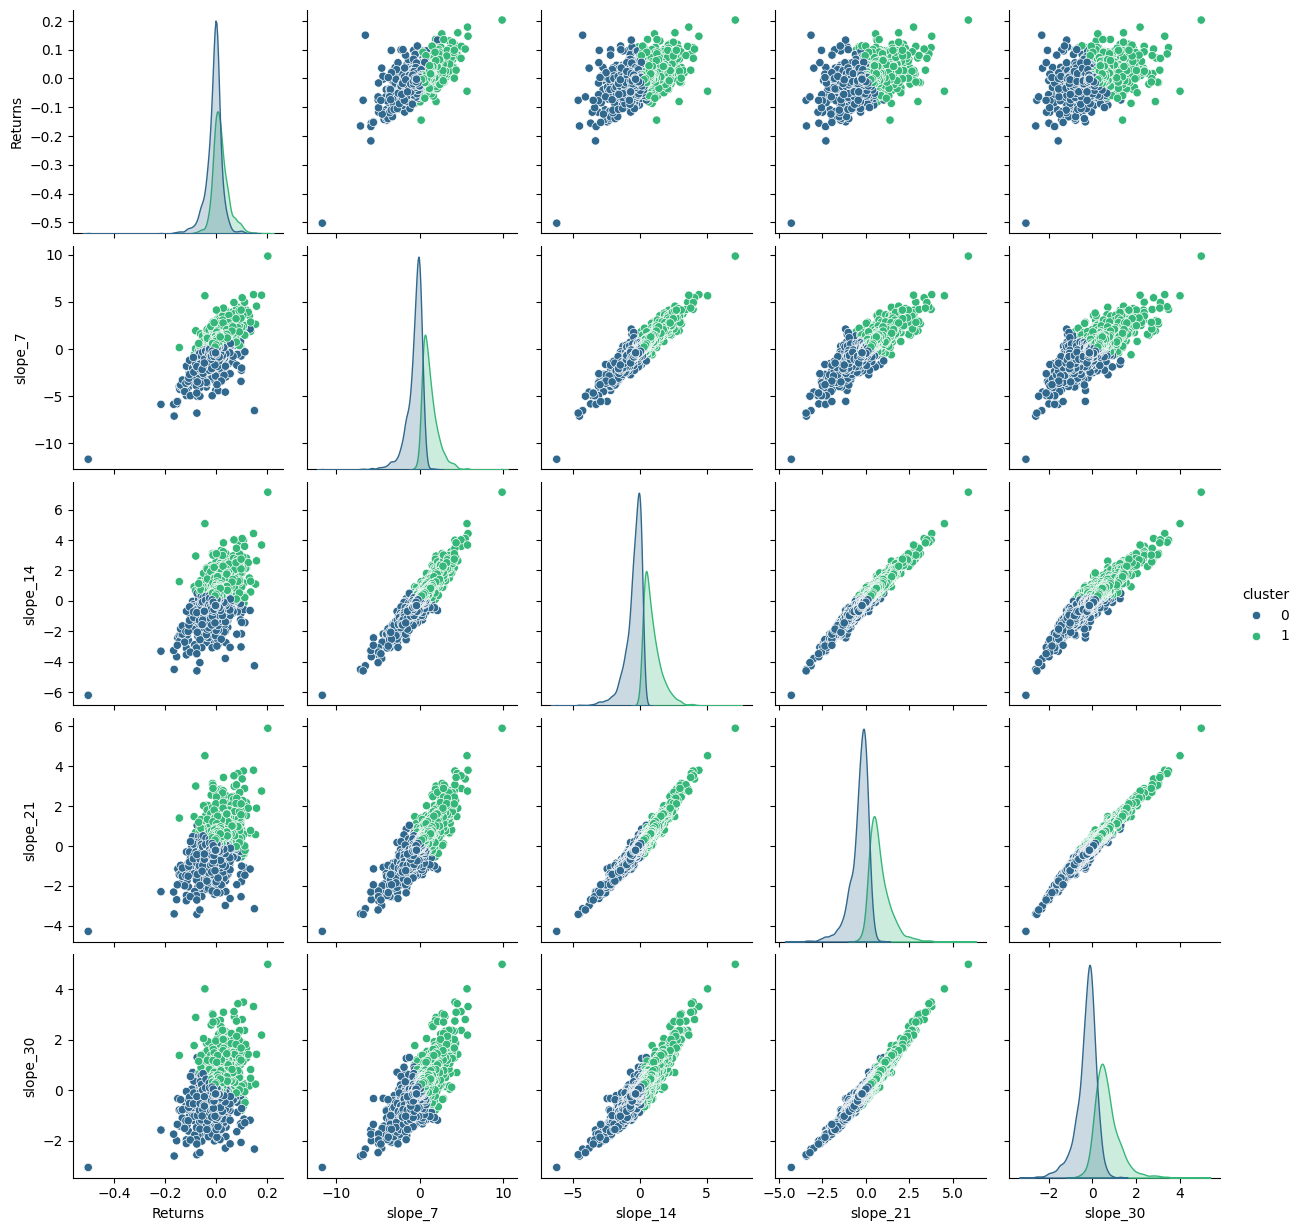

In [7]:
sns.pairplot(df_features, hue='cluster', palette='viridis', diag_kind='kde')
plt.show();

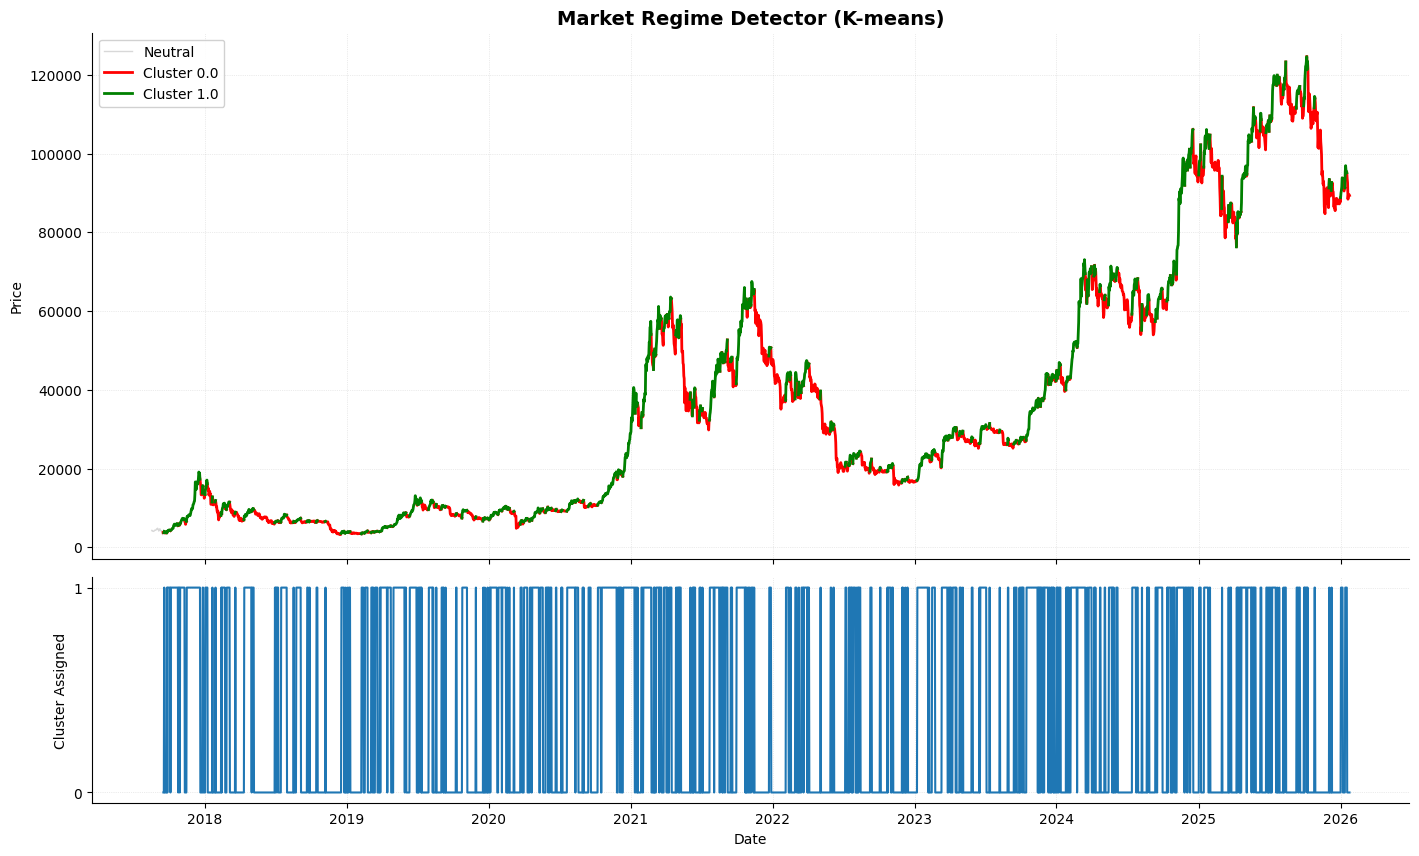

In [28]:
# Plot price by K-means
df['cluster'] = df_features['cluster']
close_neutral = df['Close']
colors = {0.0: "red", 1.0: "green"}
close_cluster = {}

for c in colors.keys():
    mask = (df['cluster'] == c) | (df['cluster'].shift(-1) == c)
    series = df['Close'].copy()
    series[~mask] = np.nan
    close_cluster[c] = series

fig, (ax1, ax2) = plt.subplots(
    2, 1, 
    figsize=(17, 10), 
    sharex=True, 
    gridspec_kw={'height_ratios': [0.7, 0.3], 'hspace': 0.05}
)

ax1.plot(df.index, close_neutral, color='gray', linewidth=1, label='Neutral', alpha=0.3)

for c, series in close_cluster.items():
    ax1.plot(df.index, series, color=colors[c], linewidth=2.0, label=f"Cluster {c}")

ax1.set_title("Market Regime Detector (K-means)", fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', frameon=True, facecolor='white', framealpha=0.9)
ax1.grid(color='gray', linestyle=':', linewidth=0.5, alpha=0.3)
ax1.set_ylabel("Price")

ax2.plot(df.index, df['cluster'], color='tab:blue', linewidth=1.5, label='Cluster')
ax2.set_yticks([0, 1])
ax2.set_ylabel("Cluster Assigned")
ax2.grid(color='gray', linestyle=':', linewidth=0.5, alpha=0.3)

for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.xlabel("Date")
plt.show();

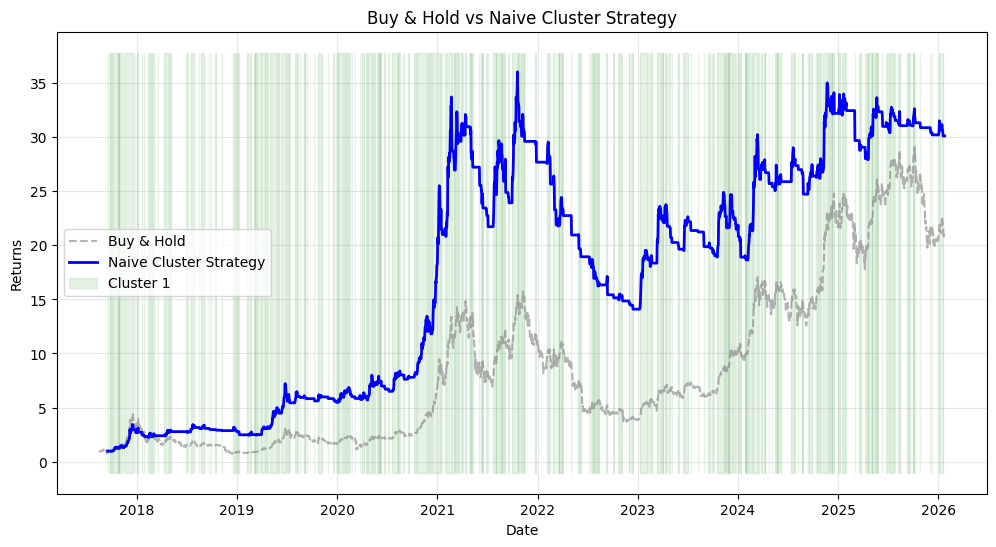

Total Returns Buy & Hold: 1985.56%
Total Returns Naive Cluster Strategy: 2910.86%


In [15]:
df['Returns'] = df['Close'].pct_change()

df['BH_Returns'] = df['Returns'].fillna(0)
df['BH_Cumulative'] = (1 + df['BH_Returns']).cumprod()

df['Signal'] = df['cluster'].shift(1)

df['Strategy_Returns'] = df['Returns'] * df['Signal']
df['Strategy_Cumulative'] = (1 + df['Strategy_Returns']).cumprod()


plt.figure(figsize=(12, 6))

plt.plot(df.index, df['BH_Cumulative'], label='Buy & Hold', color='gray', alpha=0.6, linestyle='--')

plt.plot(df.index, df['Strategy_Cumulative'], label='Naive Cluster Strategy', color='blue', linewidth=2)

y_min, y_max = plt.ylim()
plt.fill_between(df.index, y_min, y_max, where=(df['cluster']==1), 
                 color='green', alpha=0.1, label='Cluster 1')

plt.title('Buy & Hold vs Naive Cluster Strategy')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show();

total_return_bh = (df['BH_Cumulative'].iloc[-1] - 1) * 100
total_return_strat = (df['Strategy_Cumulative'].iloc[-1] - 1) * 100

print(f"Total Returns Buy & Hold: {total_return_bh:.2f}%")
print(f"Total Returns Naive Cluster Strategy: {total_return_strat:.2f}%")

### 3 clusters

In [29]:
kmeans=KMeans(n_clusters=3, random_state=1)
kmeans.fit(dataset)
df_features['cluster'] = kmeans.predict(dataset).tolist()
df_features['cluster'] = df_features['cluster'].map({0: 2, 1: 0, 2: 1})

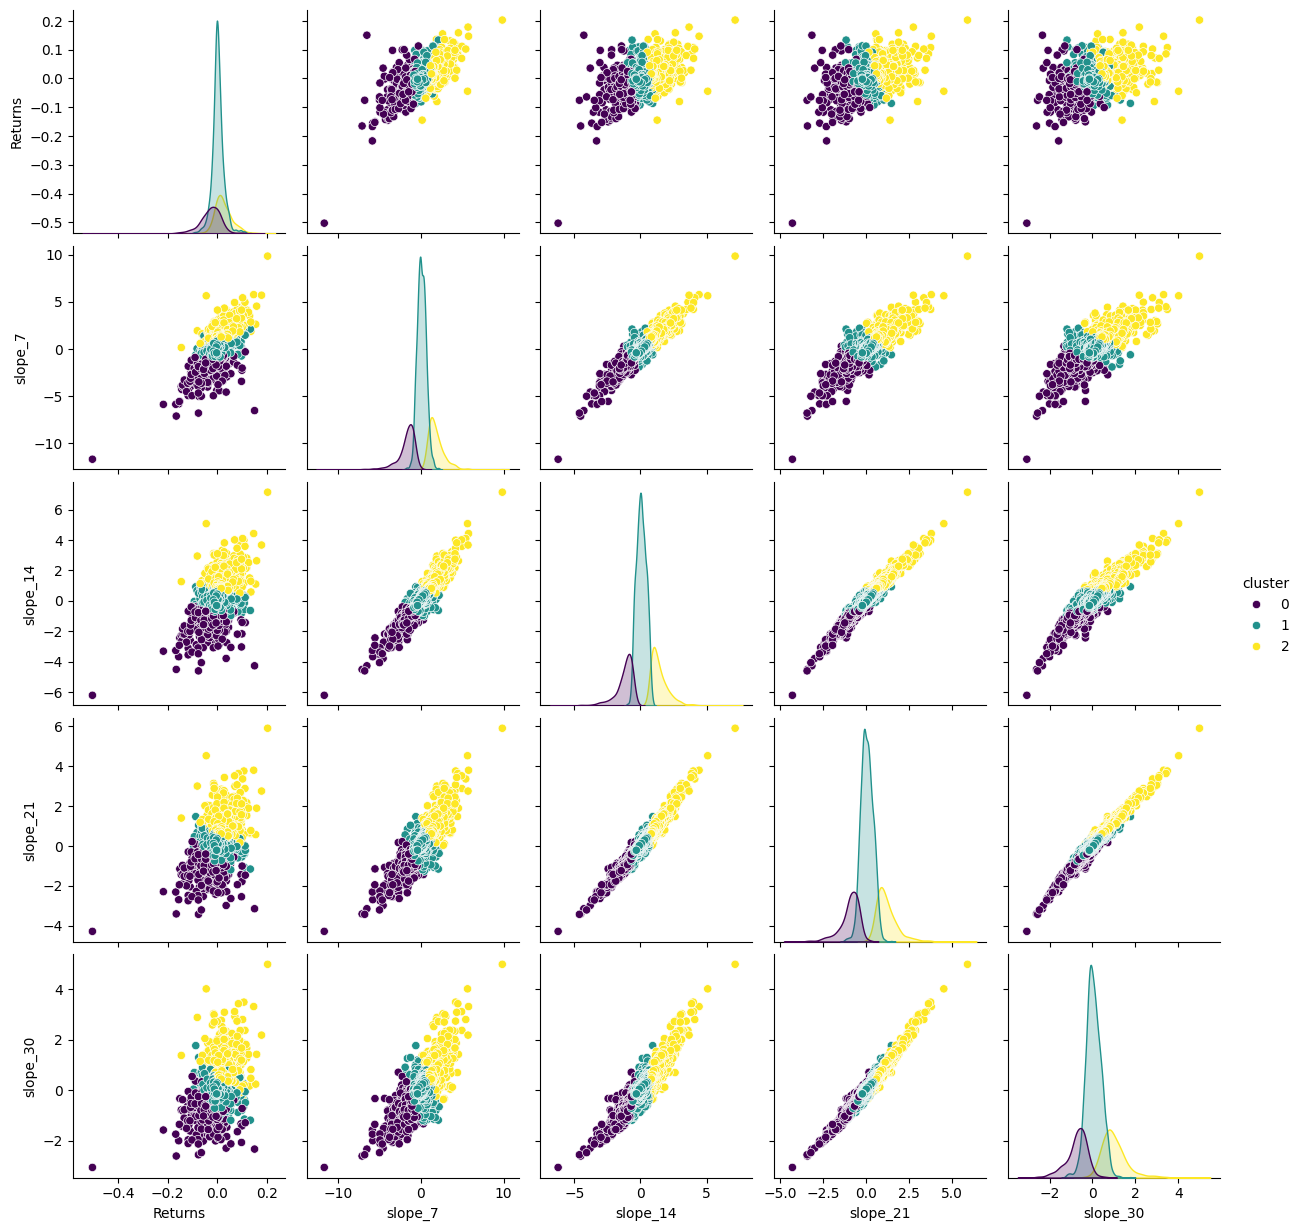

In [17]:
sns.pairplot(df_features, hue='cluster', palette='viridis', diag_kind='kde')
plt.show();

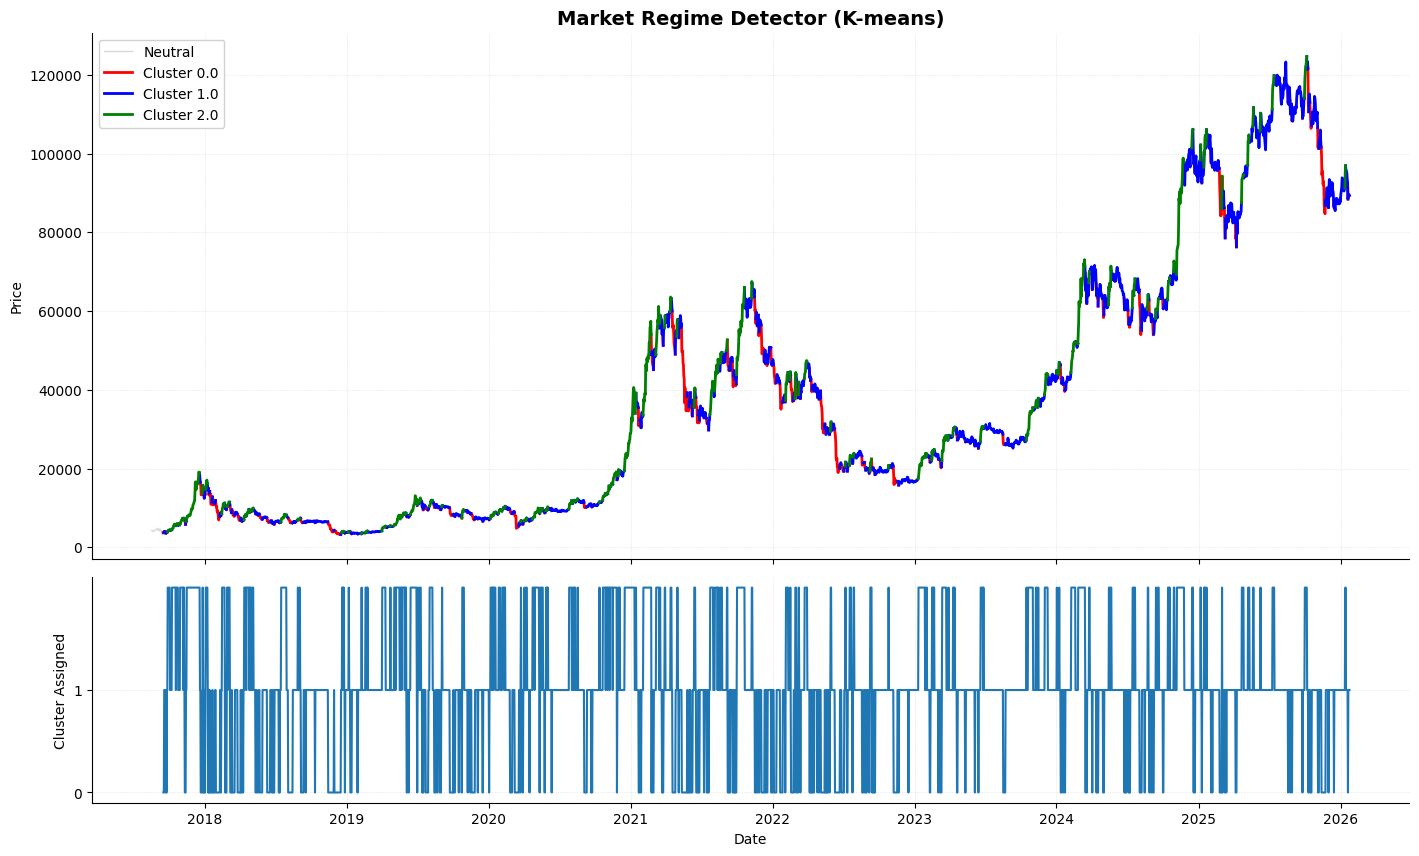

In [30]:
# Plot price by K-means
df['cluster'] = df_features['cluster']
close_neutral = df['Close']
colors = {0.0: "red", 1.0: "blue", 2.0: "green"}
close_cluster = {}

for c in colors.keys():
    mask = (df['cluster'] == c) | (df['cluster'].shift(-1) == c)
    series = df['Close'].copy()
    series[~mask] = np.nan
    close_cluster[c] = series

fig, (ax1, ax2) = plt.subplots(
    2, 1, 
    figsize=(17, 10), 
    sharex=True, 
    gridspec_kw={'height_ratios': [0.7, 0.3], 'hspace': 0.05}
)

ax1.plot(df.index, close_neutral, color='gray', linewidth=1, label='Neutral', alpha=0.3)

for c, series in close_cluster.items():
    ax1.plot(df.index, series, color=colors[c], linewidth=2.0, label=f"Cluster {c}")

ax1.set_title("Market Regime Detector (K-means)", fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', frameon=True, facecolor='white', framealpha=0.9)
ax1.grid(color='gray', linestyle=':', linewidth=0.5, alpha=0.3)
ax1.set_ylabel("Price")

ax2.plot(df.index, df['cluster'], color='tab:blue', linewidth=1.5, label='Cluster')
ax2.set_yticks([0, 1])
ax2.set_ylabel("Cluster Assigned")
ax2.grid(color='gray', linestyle=':', linewidth=0.5, alpha=0.3)

for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.xlabel("Date")
plt.show();

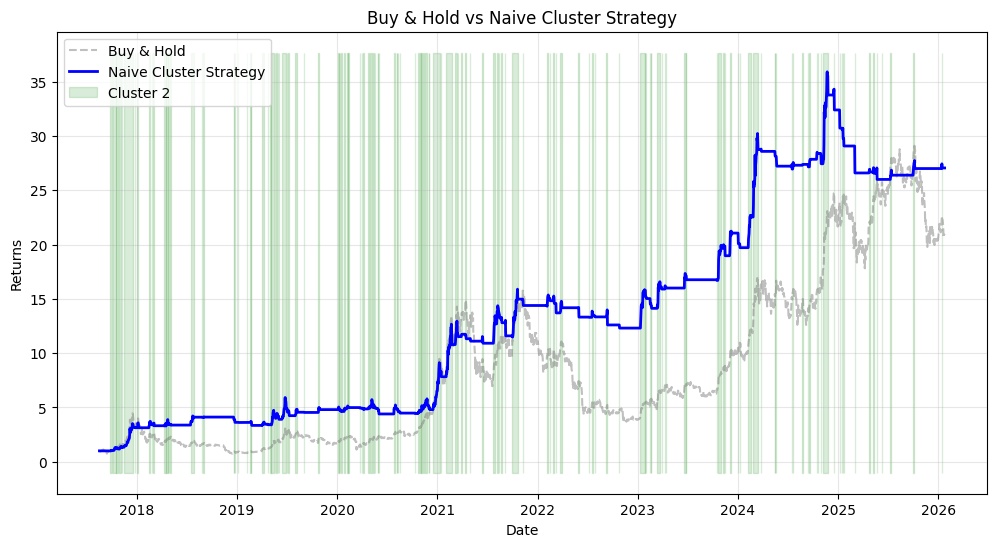

Total Returns Buy & Hold: 1985.56%
Total Returns Naive Cluster Strategy: 2605.08%


In [31]:
df['Returns'] = df['Close'].pct_change()

df['BH_Returns'] = df['Returns'].fillna(0)
df['BH_Cumulative'] = (1 + df['BH_Returns']).cumprod()

is_target_cluster = (df['cluster'] == 2)

df['Signal'] = is_target_cluster.shift(1).fillna(0).astype(int)

df['Strategy_Returns'] = df['Returns'] * df['Signal']
df['Strategy_Cumulative'] = (1 + df['Strategy_Returns']).cumprod()

plt.figure(figsize=(12, 6))

plt.plot(df.index, df['BH_Cumulative'], label='Buy & Hold', color='gray', alpha=0.5, linestyle='--')

plt.plot(df.index, df['Strategy_Cumulative'], label='Naive Cluster Strategy', color='blue', linewidth=2)

y_min, y_max = plt.ylim()
plt.fill_between(df.index, y_min, y_max, where=(df['cluster'] == 2), 
                 color='green', alpha=0.15, label='Cluster 2')

plt.title('Buy & Hold vs Naive Cluster Strategy')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

total_return_bh = (df['BH_Cumulative'].iloc[-1] - 1) * 100
total_return_strat = (df['Strategy_Cumulative'].iloc[-1] - 1) * 100

print(f"Total Returns Buy & Hold: {total_return_bh:.2f}%")
print(f"Total Returns Naive Cluster Strategy: {total_return_strat:.2f}%")

### 4 clusters

In [32]:
kmeans=KMeans(n_clusters=4, random_state=1)
kmeans.fit(dataset)
df_features['cluster'] = kmeans.predict(dataset).tolist()
df_features['cluster'] = df_features['cluster'].map({0: 3, 1: 0, 2: 1, 3: 2})

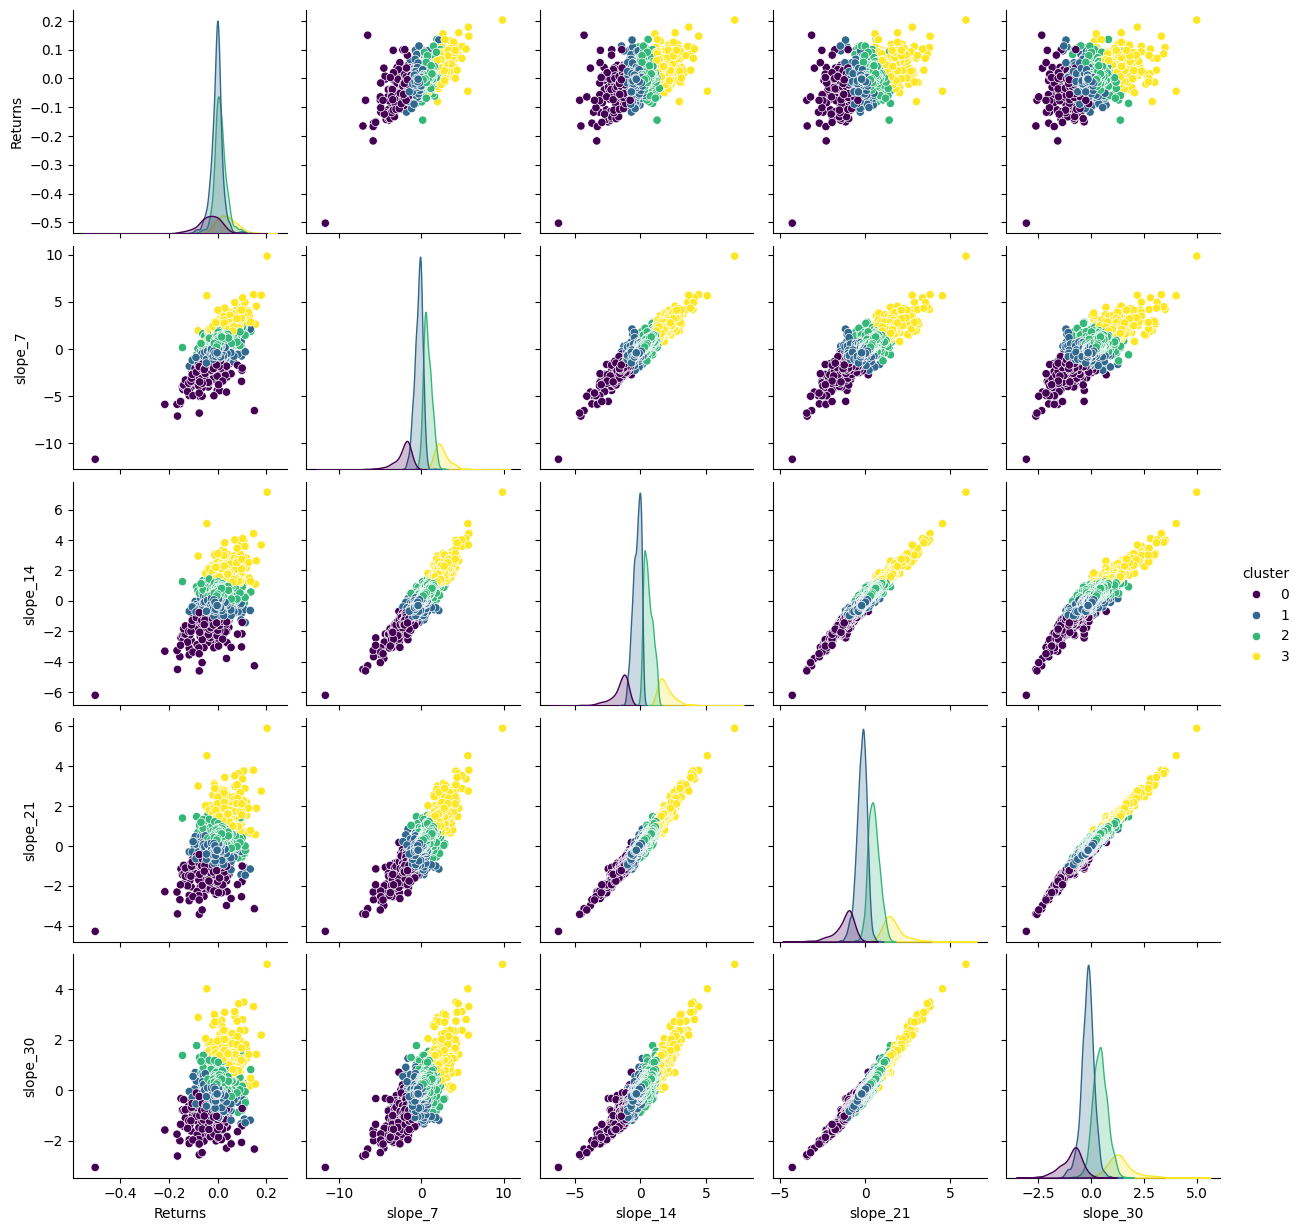

In [22]:
sns.pairplot(df_features, hue='cluster', palette='viridis', diag_kind='kde')
plt.show();

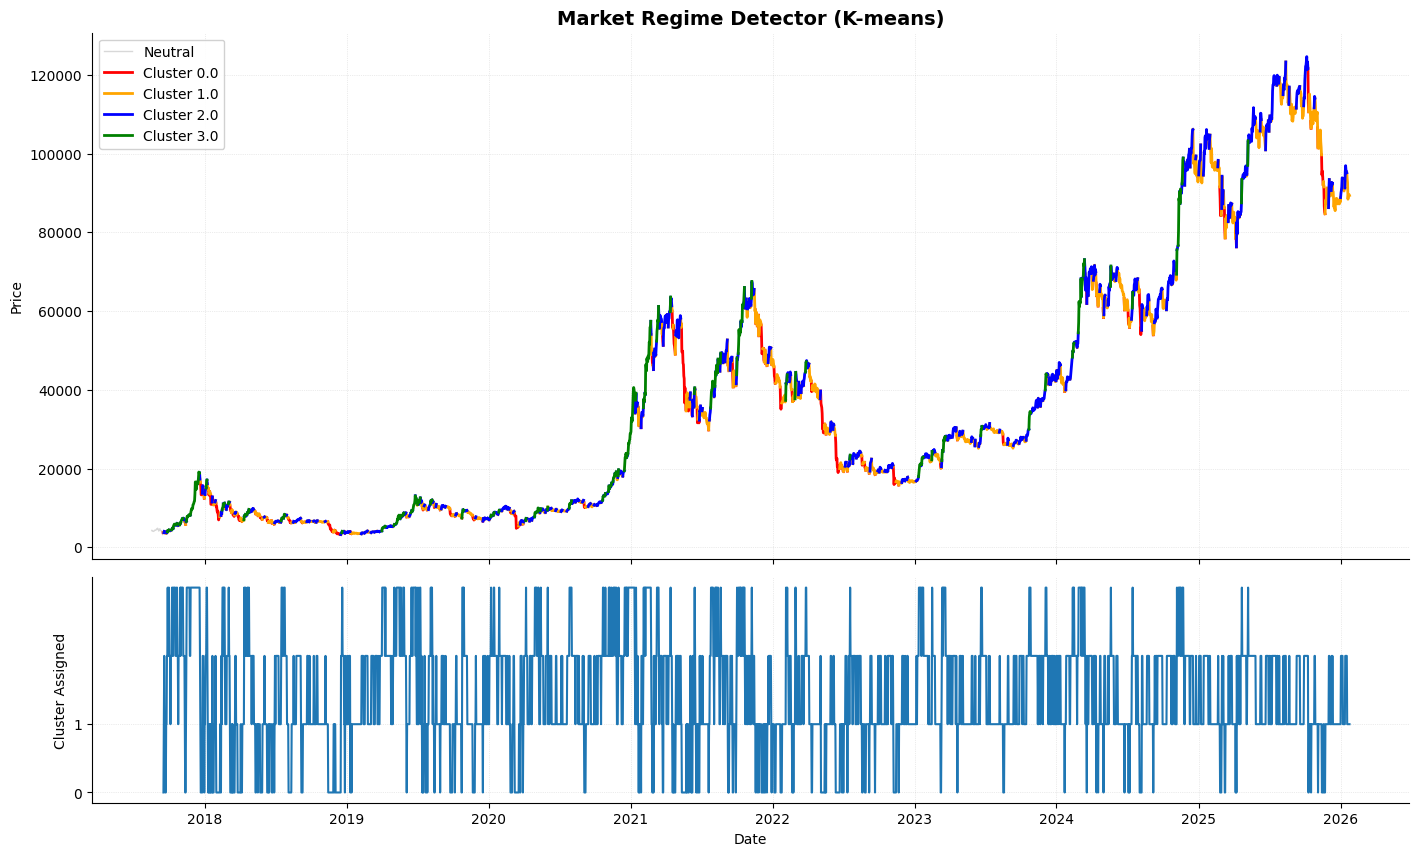

In [33]:
# Plot price by K-means
df['cluster'] = df_features['cluster']
close_neutral = df['Close']
colors = {0.0: "red", 1.0: "orange", 2.0: "blue", 3.0: "green"}
close_cluster = {}

for c in colors.keys():
    mask = (df['cluster'] == c) | (df['cluster'].shift(-1) == c)
    series = df['Close'].copy()
    series[~mask] = np.nan
    close_cluster[c] = series

fig, (ax1, ax2) = plt.subplots(
    2, 1, 
    figsize=(17, 10), 
    sharex=True, 
    gridspec_kw={'height_ratios': [0.7, 0.3], 'hspace': 0.05}
)

ax1.plot(df.index, close_neutral, color='gray', linewidth=1, label='Neutral', alpha=0.3)

for c, series in close_cluster.items():
    ax1.plot(df.index, series, color=colors[c], linewidth=2.0, label=f"Cluster {c}")

ax1.set_title("Market Regime Detector (K-means)", fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', frameon=True, facecolor='white', framealpha=0.9)
ax1.grid(color='gray', linestyle=':', linewidth=0.5, alpha=0.3)
ax1.set_ylabel("Price")

ax2.plot(df.index, df['cluster'], color='tab:blue', linewidth=1.5, label='Cluster')
ax2.set_yticks([0, 1])
ax2.set_ylabel("Cluster Assigned")
ax2.grid(color='gray', linestyle=':', linewidth=0.5, alpha=0.3)

for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.xlabel("Date")
plt.show();

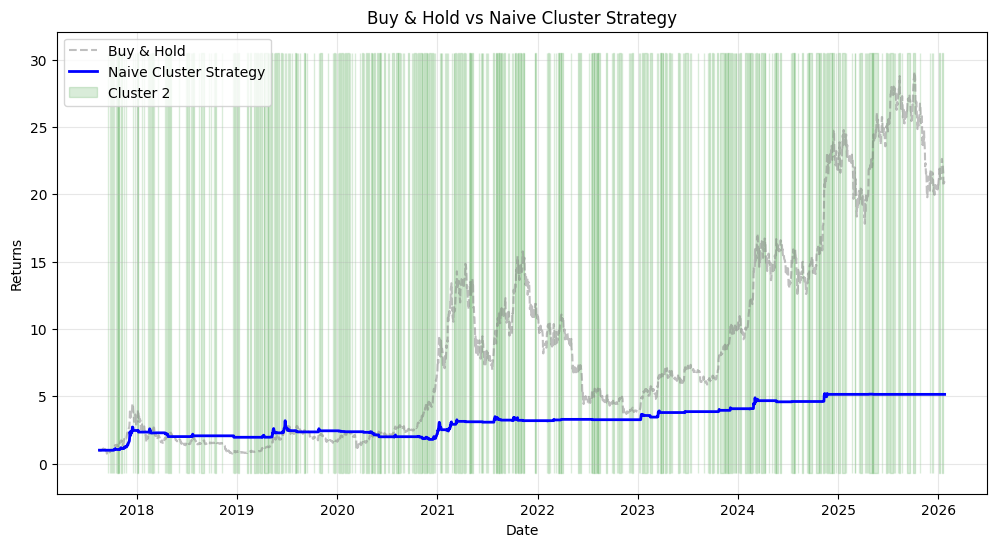

Total Returns Buy & Hold: 1985.56%
Total Returns Naive Cluster Strategy: 414.46%


In [34]:
df['Returns'] = df['Close'].pct_change()

df['BH_Returns'] = df['Returns'].fillna(0)
df['BH_Cumulative'] = (1 + df['BH_Returns']).cumprod()

is_target_cluster = (df['cluster'] == 3)

df['Signal'] = is_target_cluster.shift(1).fillna(0).astype(int)

df['Strategy_Returns'] = df['Returns'] * df['Signal']
df['Strategy_Cumulative'] = (1 + df['Strategy_Returns']).cumprod()

plt.figure(figsize=(12, 6))

plt.plot(df.index, df['BH_Cumulative'], label='Buy & Hold', color='gray', alpha=0.5, linestyle='--')

plt.plot(df.index, df['Strategy_Cumulative'], label='Naive Cluster Strategy', color='blue', linewidth=2)

y_min, y_max = plt.ylim()
plt.fill_between(df.index, y_min, y_max, where=(df['cluster'] == 2), 
                 color='green', alpha=0.15, label='Cluster 2')

plt.title('Buy & Hold vs Naive Cluster Strategy')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

total_return_bh = (df['BH_Cumulative'].iloc[-1] - 1) * 100
total_return_strat = (df['Strategy_Cumulative'].iloc[-1] - 1) * 100

print(f"Total Returns Buy & Hold: {total_return_bh:.2f}%")
print(f"Total Returns Naive Cluster Strategy: {total_return_strat:.2f}%")

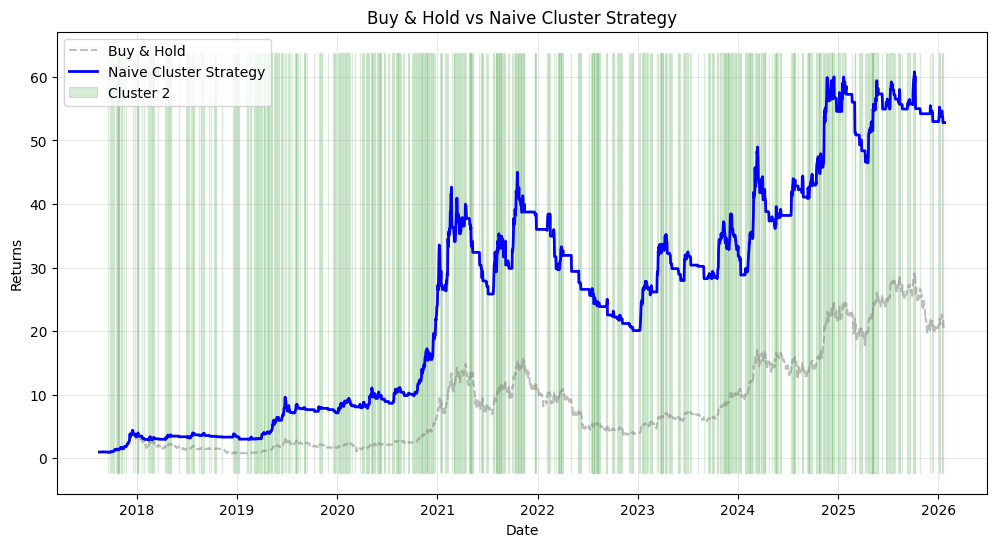

Total Returns Buy & Hold: 1985.56%
Total Returns Naive Cluster Strategy: 5179.80%


In [35]:
df['Returns'] = df['Close'].pct_change()

df['BH_Returns'] = df['Returns'].fillna(0)
df['BH_Cumulative'] = (1 + df['BH_Returns']).cumprod()

is_target_cluster = (df['cluster'] >= 2)

df['Signal'] = is_target_cluster.shift(1).fillna(0).astype(int)

df['Strategy_Returns'] = df['Returns'] * df['Signal']
df['Strategy_Cumulative'] = (1 + df['Strategy_Returns']).cumprod()

plt.figure(figsize=(12, 6))

plt.plot(df.index, df['BH_Cumulative'], label='Buy & Hold', color='gray', alpha=0.5, linestyle='--')

plt.plot(df.index, df['Strategy_Cumulative'], label='Naive Cluster Strategy', color='blue', linewidth=2)

y_min, y_max = plt.ylim()
plt.fill_between(df.index, y_min, y_max, where=(df['cluster'] == 2), 
                 color='green', alpha=0.15, label='Cluster 2')

plt.title('Buy & Hold vs Naive Cluster Strategy')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

total_return_bh = (df['BH_Cumulative'].iloc[-1] - 1) * 100
total_return_strat = (df['Strategy_Cumulative'].iloc[-1] - 1) * 100

print(f"Total Returns Buy & Hold: {total_return_bh:.2f}%")
print(f"Total Returns Naive Cluster Strategy: {total_return_strat:.2f}%")

## WK-Means

### 2 clusters

In [36]:
wkmeans = WKMeans(k=2, seed=42)
wkmeans.fit(dataset)
df_features['cluster'] = wkmeans.predict(dataset)
df['cluster'] = df_features['cluster']
df.dropna(inplace=True)

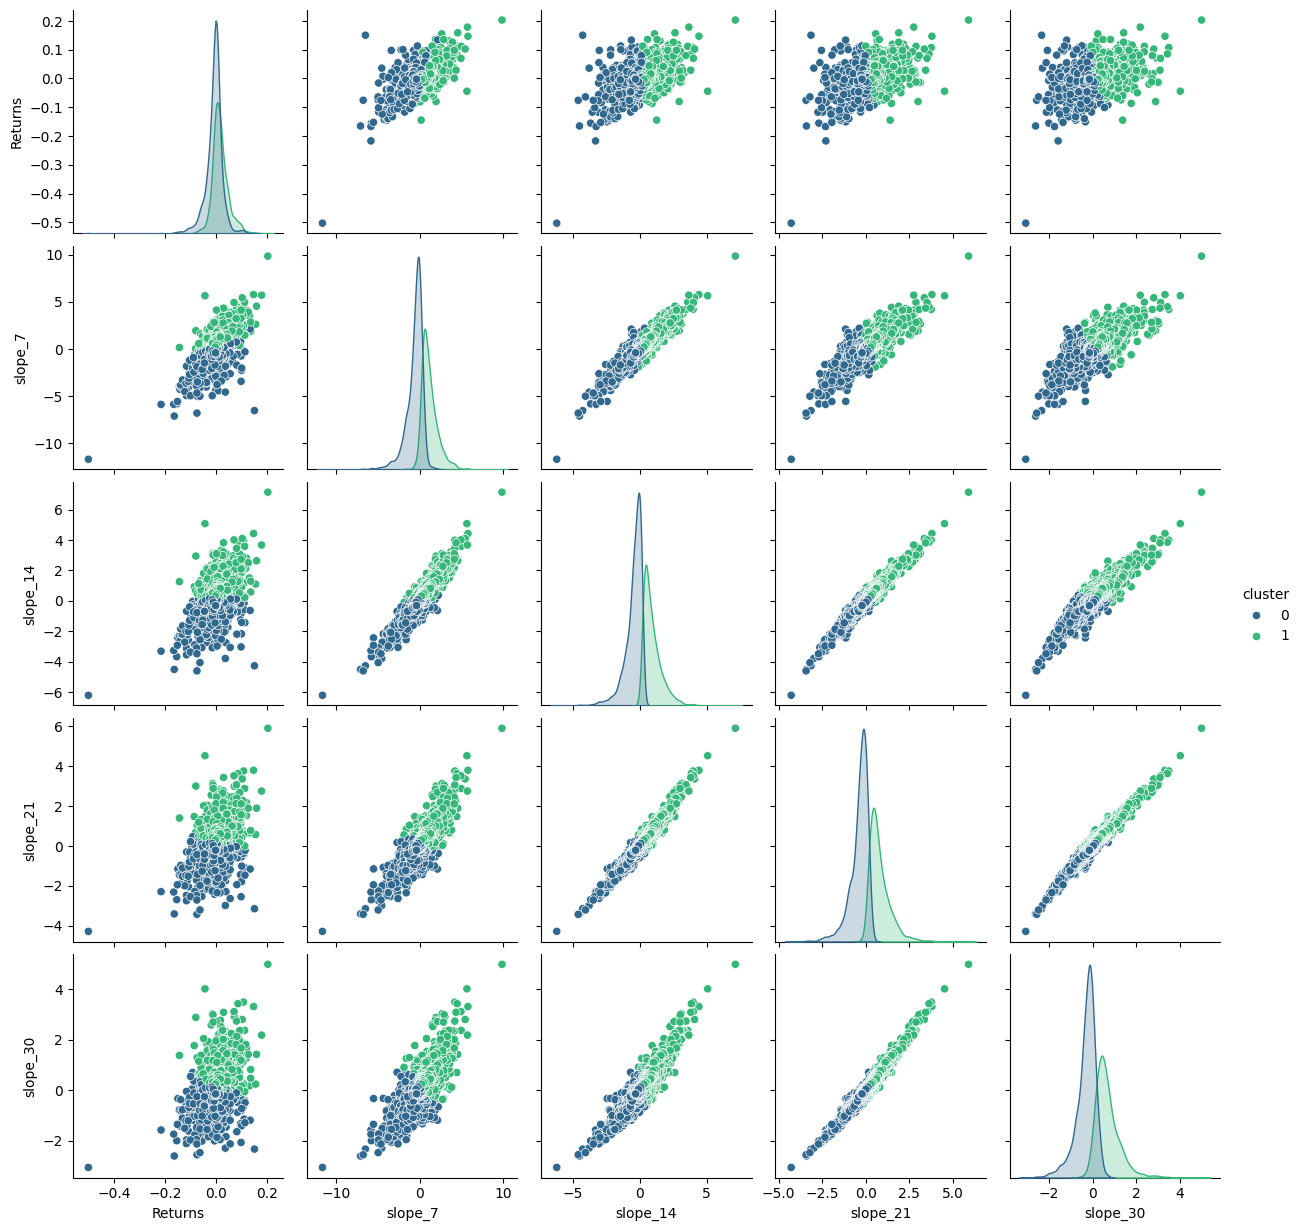

In [37]:
sns.pairplot(df_features, hue='cluster', palette='viridis', diag_kind='kde')
plt.show();

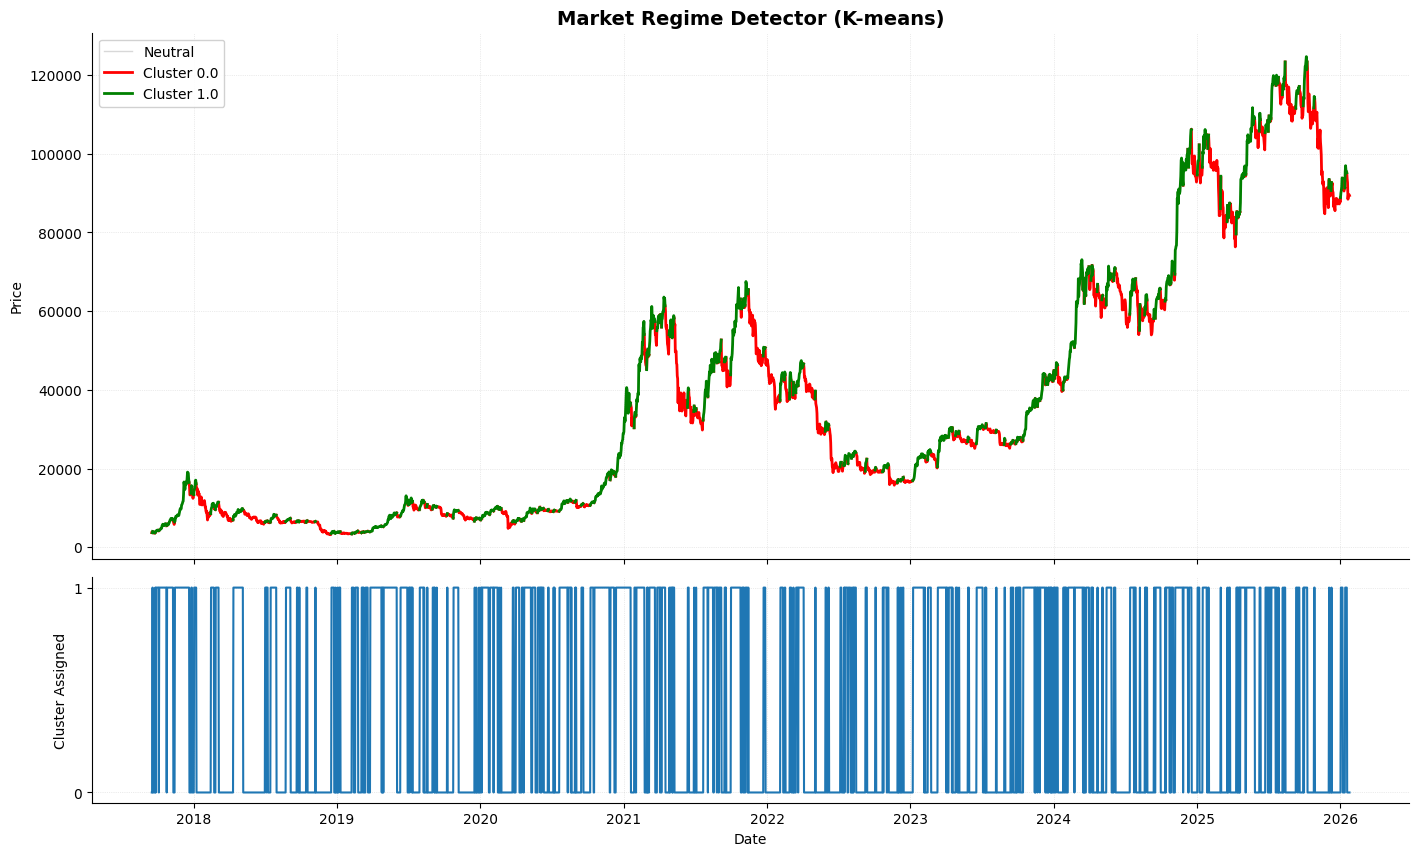

In [38]:
# Plot price by WK-means
close_neutral = df['Close']
colors = {0.0: "red", 1.0: "green"}
close_cluster = {}

for c in colors.keys():
    mask = (df['cluster'] == c) | (df['cluster'].shift(-1) == c)
    series = df['Close'].copy()
    series[~mask] = np.nan
    close_cluster[c] = series

fig, (ax1, ax2) = plt.subplots(
    2, 1, 
    figsize=(17, 10), 
    sharex=True, 
    gridspec_kw={'height_ratios': [0.7, 0.3], 'hspace': 0.05}
)

ax1.plot(df.index, close_neutral, color='gray', linewidth=1, label='Neutral', alpha=0.3)

for c, series in close_cluster.items():
    ax1.plot(df.index, series, color=colors[c], linewidth=2.0, label=f"Cluster {c}")

ax1.set_title("Market Regime Detector (K-means)", fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', frameon=True, facecolor='white', framealpha=0.9)
ax1.grid(color='gray', linestyle=':', linewidth=0.5, alpha=0.3)
ax1.set_ylabel("Price")

ax2.plot(df.index, df['cluster'], color='tab:blue', linewidth=1.5, label='Cluster')
ax2.set_yticks([0, 1])
ax2.set_ylabel("Cluster Assigned")
ax2.grid(color='gray', linestyle=':', linewidth=0.5, alpha=0.3)

for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.xlabel("Date")
plt.show();

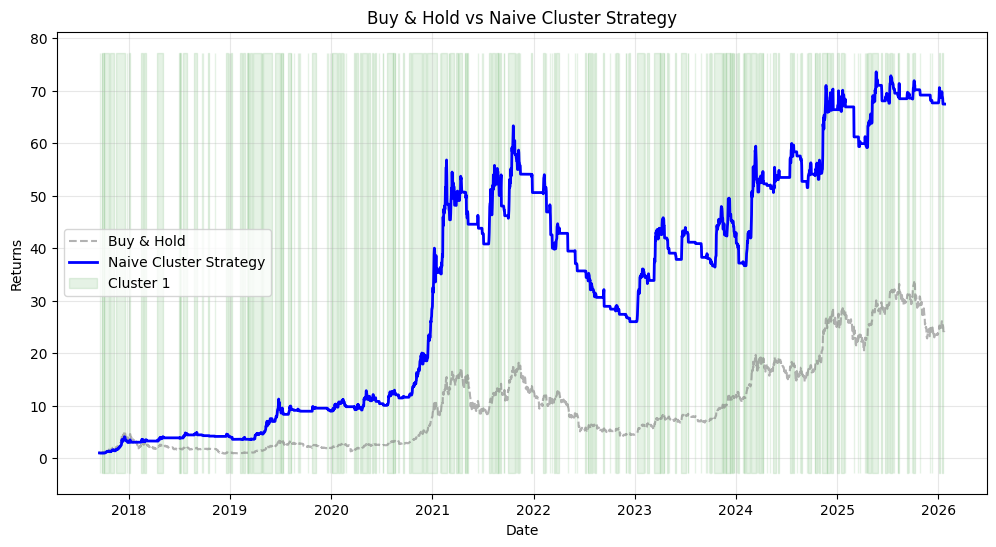

Total Returns Buy & Hold: 2305.63%
Total Returns Naive Cluster Strategy: 6646.17%


In [39]:
df['Returns'] = df['Close'].pct_change()

df['BH_Returns'] = df['Returns'].fillna(0)
df['BH_Cumulative'] = (1 + df['BH_Returns']).cumprod()

df['Signal'] = df['cluster'].shift(1)

df['Strategy_Returns'] = df['Returns'] * df['Signal']
df['Strategy_Cumulative'] = (1 + df['Strategy_Returns']).cumprod()


plt.figure(figsize=(12, 6))

plt.plot(df.index, df['BH_Cumulative'], label='Buy & Hold', color='gray', alpha=0.6, linestyle='--')

plt.plot(df.index, df['Strategy_Cumulative'], label='Naive Cluster Strategy', color='blue', linewidth=2)

y_min, y_max = plt.ylim()
plt.fill_between(df.index, y_min, y_max, where=(df['cluster']==1), 
                 color='green', alpha=0.1, label='Cluster 1')

plt.title('Buy & Hold vs Naive Cluster Strategy')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show();

total_return_bh = (df['BH_Cumulative'].iloc[-1] - 1) * 100
total_return_strat = (df['Strategy_Cumulative'].iloc[-1] - 1) * 100

print(f"Total Returns Buy & Hold: {total_return_bh:.2f}%")
print(f"Total Returns Naive Cluster Strategy: {total_return_strat:.2f}%")

### 3 clusters

In [40]:
wkmeans = WKMeans(k=3, seed=42)
wkmeans.fit(dataset)
df_features['cluster'] = wkmeans.predict(dataset)
df['cluster'] = df_features['cluster']
df.dropna(inplace=True)

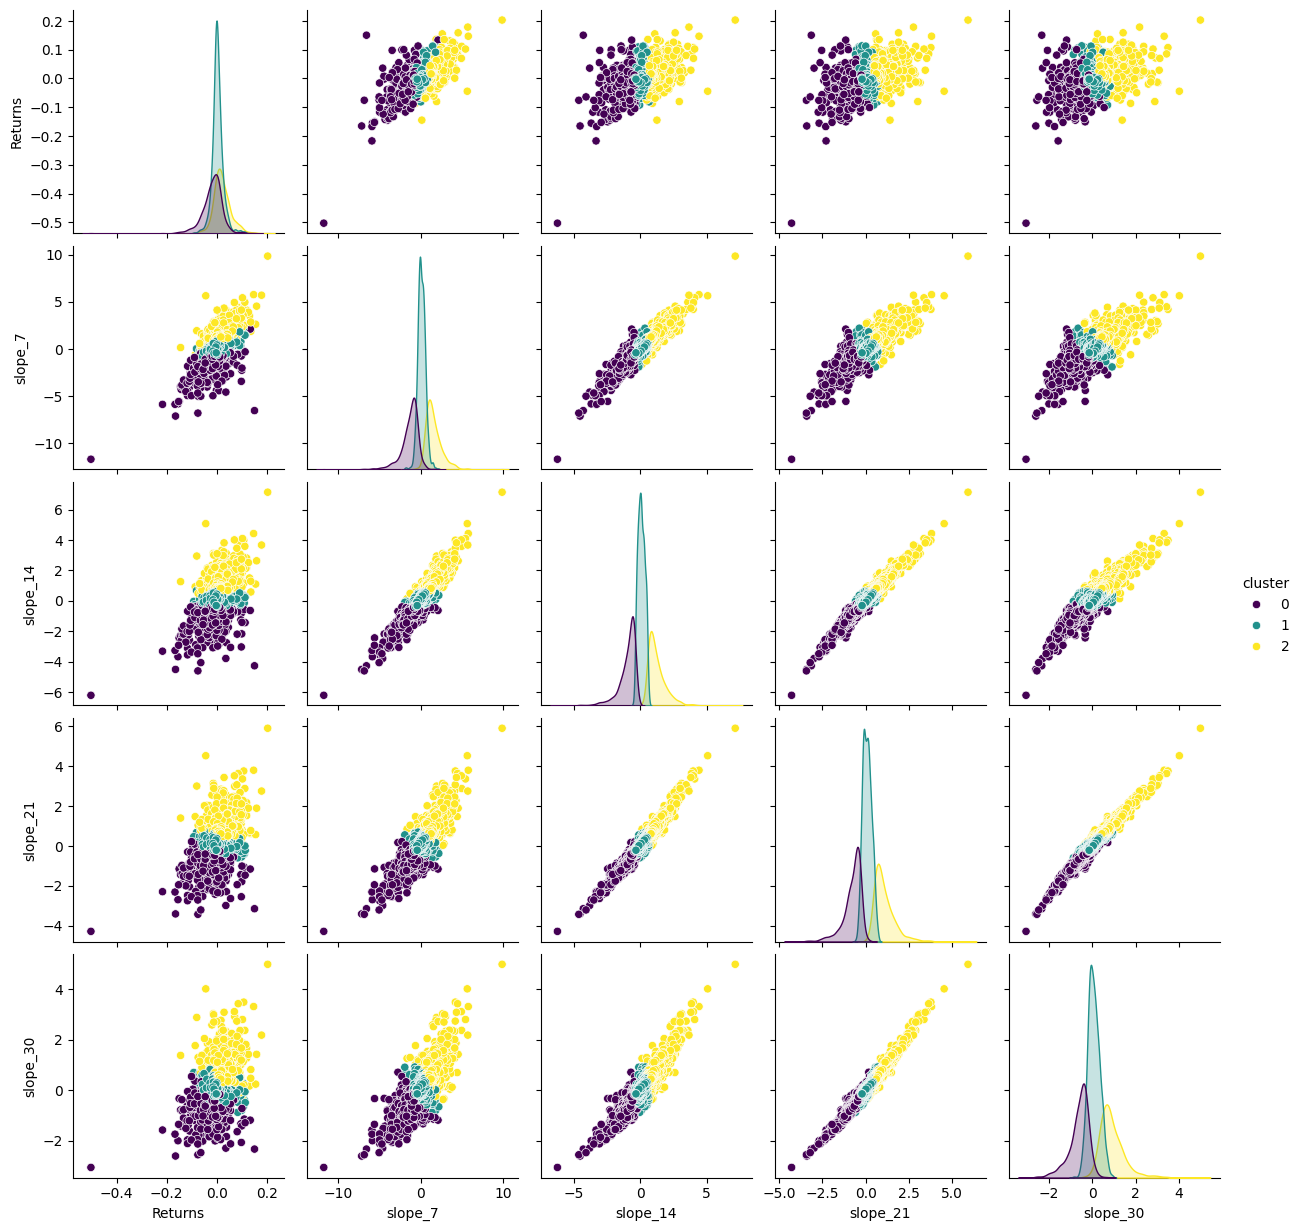

In [41]:
sns.pairplot(df_features, hue='cluster', palette='viridis', diag_kind='kde')
plt.show();

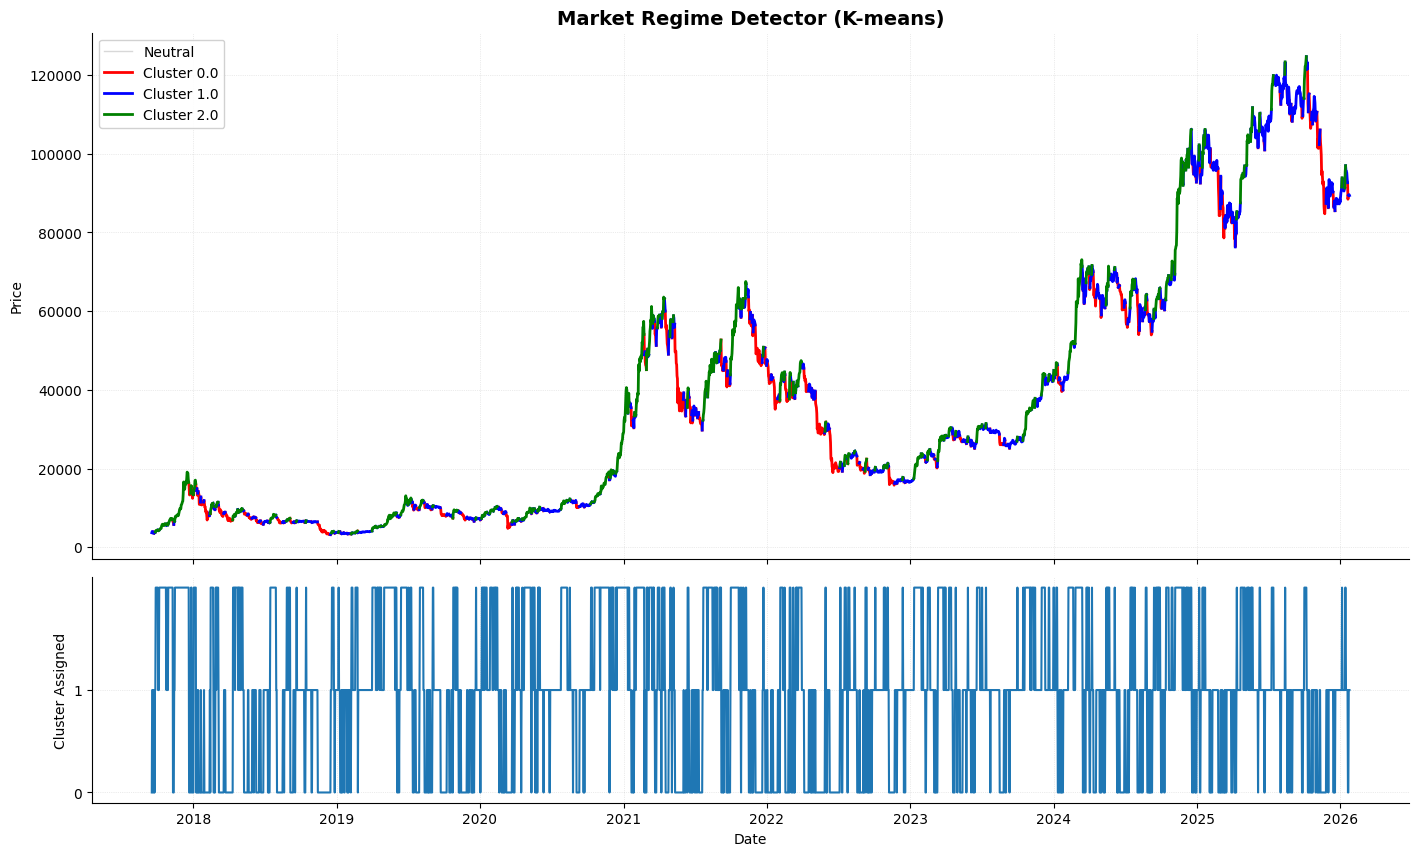

In [42]:
# Plot price by WK-means
close_neutral = df['Close']
colors = {0.0: "red", 1.0: "blue", 2.0: "green"}
close_cluster = {}

for c in colors.keys():
    mask = (df['cluster'] == c) | (df['cluster'].shift(-1) == c)
    series = df['Close'].copy()
    series[~mask] = np.nan
    close_cluster[c] = series

fig, (ax1, ax2) = plt.subplots(
    2, 1, 
    figsize=(17, 10), 
    sharex=True, 
    gridspec_kw={'height_ratios': [0.7, 0.3], 'hspace': 0.05}
)

ax1.plot(df.index, close_neutral, color='gray', linewidth=1, label='Neutral', alpha=0.3)

for c, series in close_cluster.items():
    ax1.plot(df.index, series, color=colors[c], linewidth=2.0, label=f"Cluster {c}")

ax1.set_title("Market Regime Detector (K-means)", fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', frameon=True, facecolor='white', framealpha=0.9)
ax1.grid(color='gray', linestyle=':', linewidth=0.5, alpha=0.3)
ax1.set_ylabel("Price")

ax2.plot(df.index, df['cluster'], color='tab:blue', linewidth=1.5, label='Cluster')
ax2.set_yticks([0, 1])
ax2.set_ylabel("Cluster Assigned")
ax2.grid(color='gray', linestyle=':', linewidth=0.5, alpha=0.3)

for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.xlabel("Date")
plt.show();

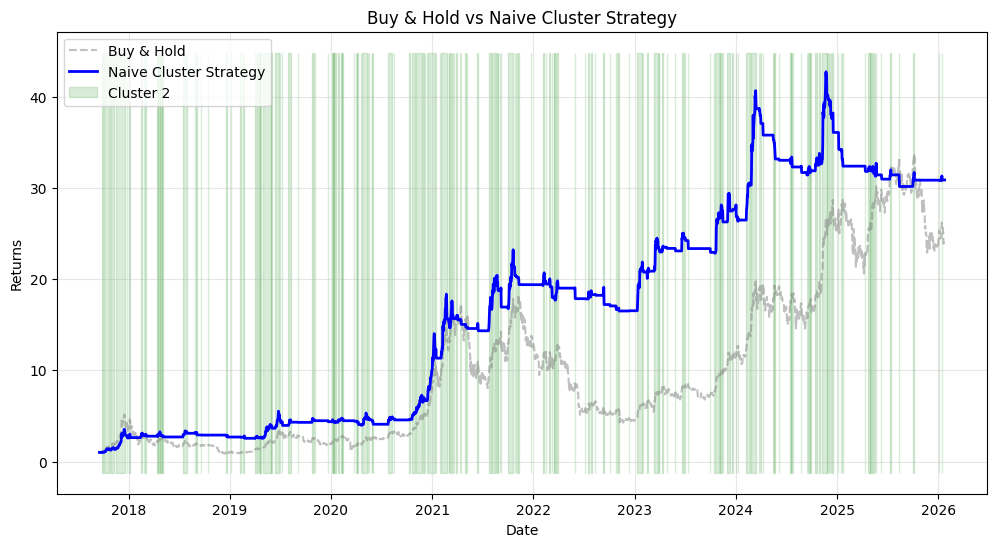

Total Returns Buy & Hold: 2315.36%
Total Returns Naive Cluster Strategy: 2987.86%


In [43]:
df['Returns'] = df['Close'].pct_change()

df['BH_Returns'] = df['Returns'].fillna(0)
df['BH_Cumulative'] = (1 + df['BH_Returns']).cumprod()

is_target_cluster = (df['cluster'] == 2)

df['Signal'] = is_target_cluster.shift(1).fillna(0).astype(int)

df['Strategy_Returns'] = df['Returns'] * df['Signal']
df['Strategy_Cumulative'] = (1 + df['Strategy_Returns']).cumprod()

plt.figure(figsize=(12, 6))

plt.plot(df.index, df['BH_Cumulative'], label='Buy & Hold', color='gray', alpha=0.5, linestyle='--')

plt.plot(df.index, df['Strategy_Cumulative'], label='Naive Cluster Strategy', color='blue', linewidth=2)

y_min, y_max = plt.ylim()
plt.fill_between(df.index, y_min, y_max, where=(df['cluster'] == 2), 
                 color='green', alpha=0.15, label='Cluster 2')

plt.title('Buy & Hold vs Naive Cluster Strategy')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

total_return_bh = (df['BH_Cumulative'].iloc[-1] - 1) * 100
total_return_strat = (df['Strategy_Cumulative'].iloc[-1] - 1) * 100

print(f"Total Returns Buy & Hold: {total_return_bh:.2f}%")
print(f"Total Returns Naive Cluster Strategy: {total_return_strat:.2f}%")

### 4 clusters

In [44]:
wkmeans = WKMeans(k=4, seed=42)
wkmeans.fit(dataset)
df_features['cluster'] = wkmeans.predict(dataset)
df_features['cluster'] = df_features['cluster'].map({0: 0, 1: 1, 2: 3, 3: 2})
df['cluster'] = df_features['cluster']
df.dropna(inplace=True)

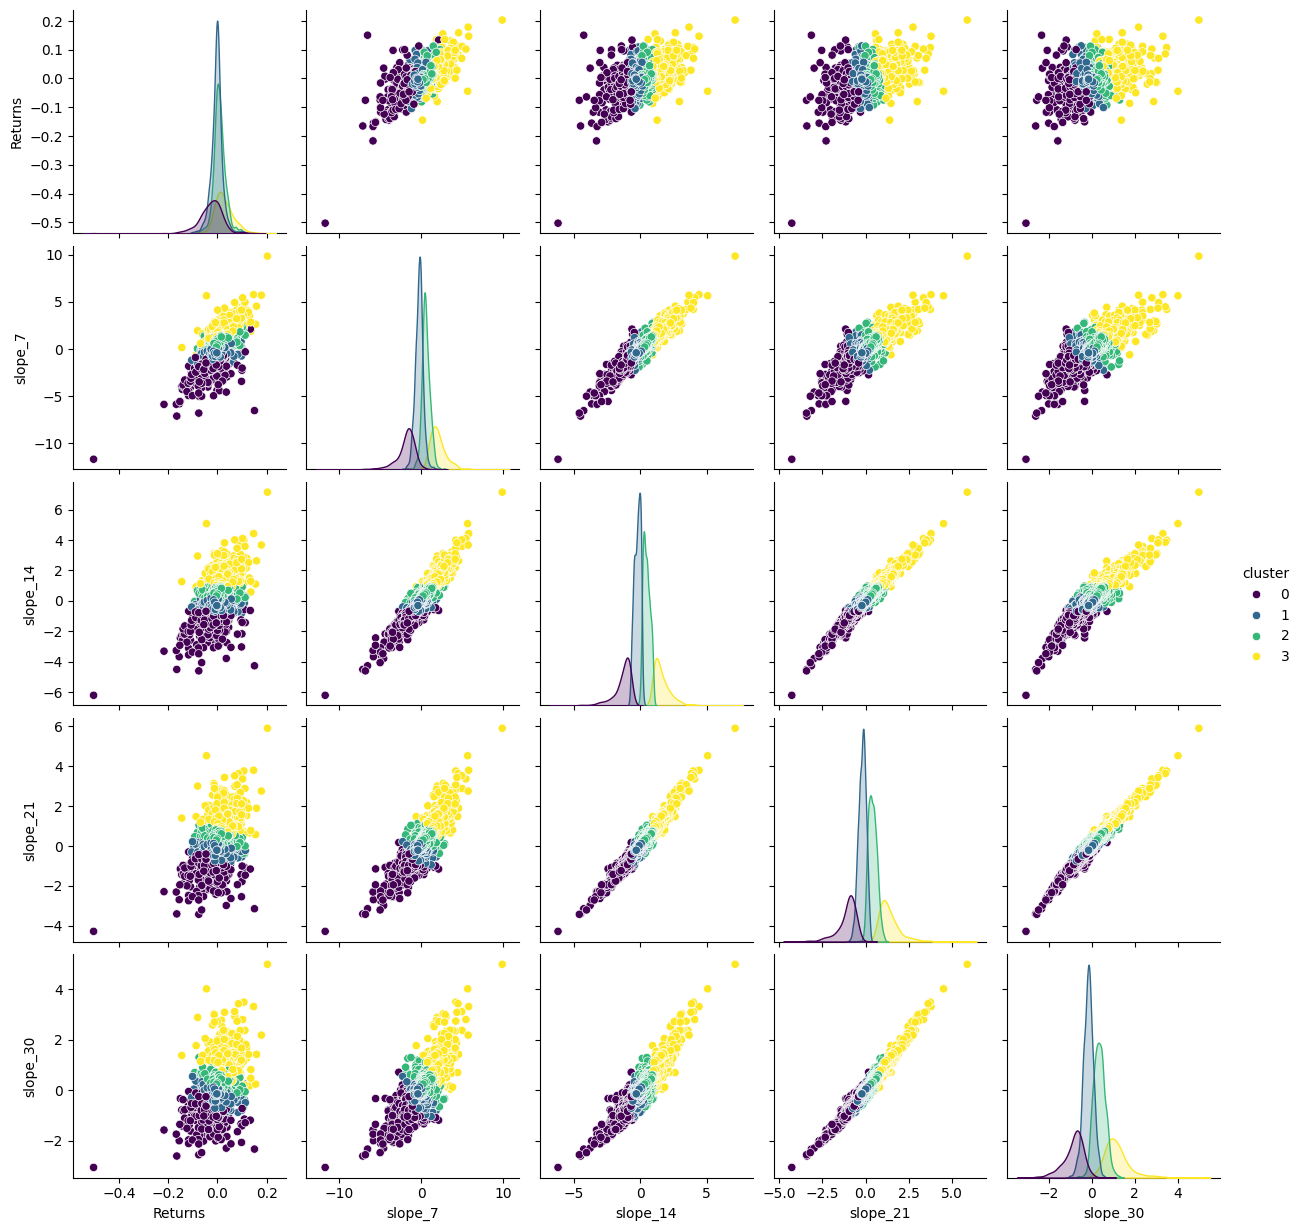

In [45]:
sns.pairplot(df_features, hue='cluster', palette='viridis', diag_kind='kde')
plt.show();

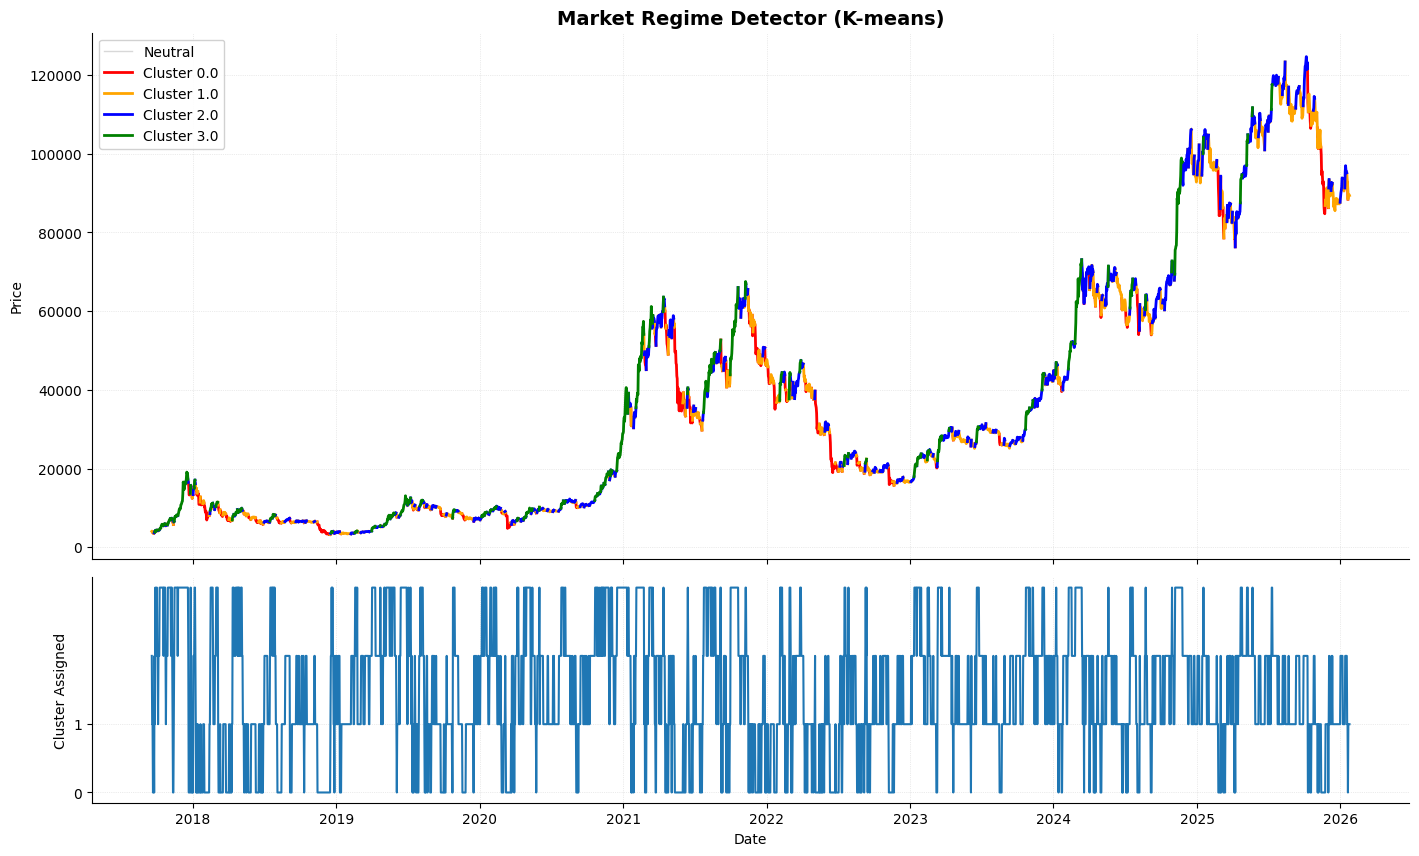

In [46]:
# Plot price by WK-means
close_neutral = df['Close']
colors = {0.0: "red", 1.0: "orange", 2.0: "blue", 3.0: "green"}
close_cluster = {}

for c in colors.keys():
    mask = (df['cluster'] == c) | (df['cluster'].shift(-1) == c)
    series = df['Close'].copy()
    series[~mask] = np.nan
    close_cluster[c] = series

fig, (ax1, ax2) = plt.subplots(
    2, 1, 
    figsize=(17, 10), 
    sharex=True, 
    gridspec_kw={'height_ratios': [0.7, 0.3], 'hspace': 0.05}
)

ax1.plot(df.index, close_neutral, color='gray', linewidth=1, label='Neutral', alpha=0.3)

for c, series in close_cluster.items():
    ax1.plot(df.index, series, color=colors[c], linewidth=2.0, label=f"Cluster {c}")

ax1.set_title("Market Regime Detector (K-means)", fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', frameon=True, facecolor='white', framealpha=0.9)
ax1.grid(color='gray', linestyle=':', linewidth=0.5, alpha=0.3)
ax1.set_ylabel("Price")

ax2.plot(df.index, df['cluster'], color='tab:blue', linewidth=1.5, label='Cluster')
ax2.set_yticks([0, 1])
ax2.set_ylabel("Cluster Assigned")
ax2.grid(color='gray', linestyle=':', linewidth=0.5, alpha=0.3)

for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.xlabel("Date")
plt.show();

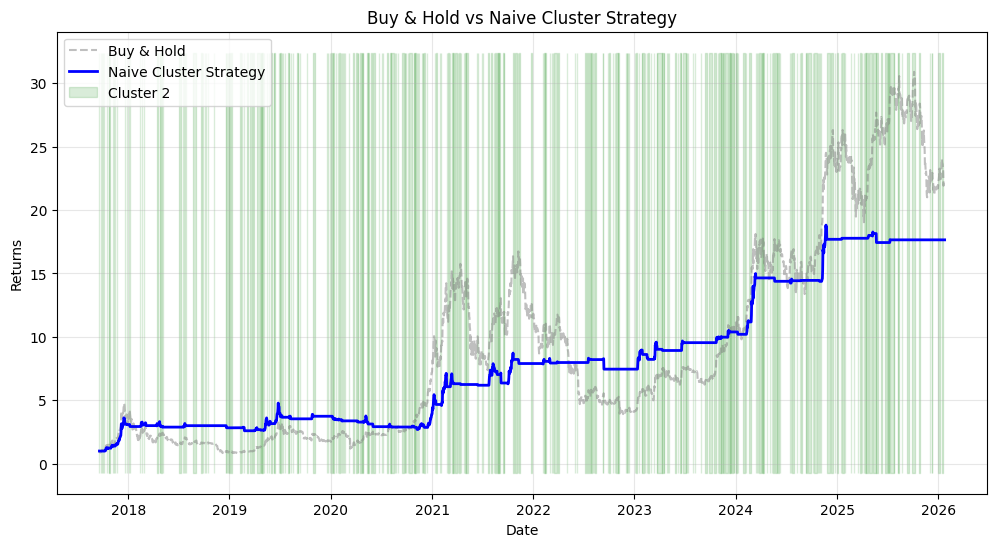

Total Returns Buy & Hold: 2114.81%
Total Returns Naive Cluster Strategy: 1664.80%


In [47]:
df['Returns'] = df['Close'].pct_change()

df['BH_Returns'] = df['Returns'].fillna(0)
df['BH_Cumulative'] = (1 + df['BH_Returns']).cumprod()

is_target_cluster = (df['cluster'] == 3)

df['Signal'] = is_target_cluster.shift(1).fillna(0).astype(int)

df['Strategy_Returns'] = df['Returns'] * df['Signal']
df['Strategy_Cumulative'] = (1 + df['Strategy_Returns']).cumprod()

plt.figure(figsize=(12, 6))

plt.plot(df.index, df['BH_Cumulative'], label='Buy & Hold', color='gray', alpha=0.5, linestyle='--')

plt.plot(df.index, df['Strategy_Cumulative'], label='Naive Cluster Strategy', color='blue', linewidth=2)

y_min, y_max = plt.ylim()
plt.fill_between(df.index, y_min, y_max, where=(df['cluster'] == 2), 
                 color='green', alpha=0.15, label='Cluster 2')

plt.title('Buy & Hold vs Naive Cluster Strategy')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

total_return_bh = (df['BH_Cumulative'].iloc[-1] - 1) * 100
total_return_strat = (df['Strategy_Cumulative'].iloc[-1] - 1) * 100

print(f"Total Returns Buy & Hold: {total_return_bh:.2f}%")
print(f"Total Returns Naive Cluster Strategy: {total_return_strat:.2f}%")

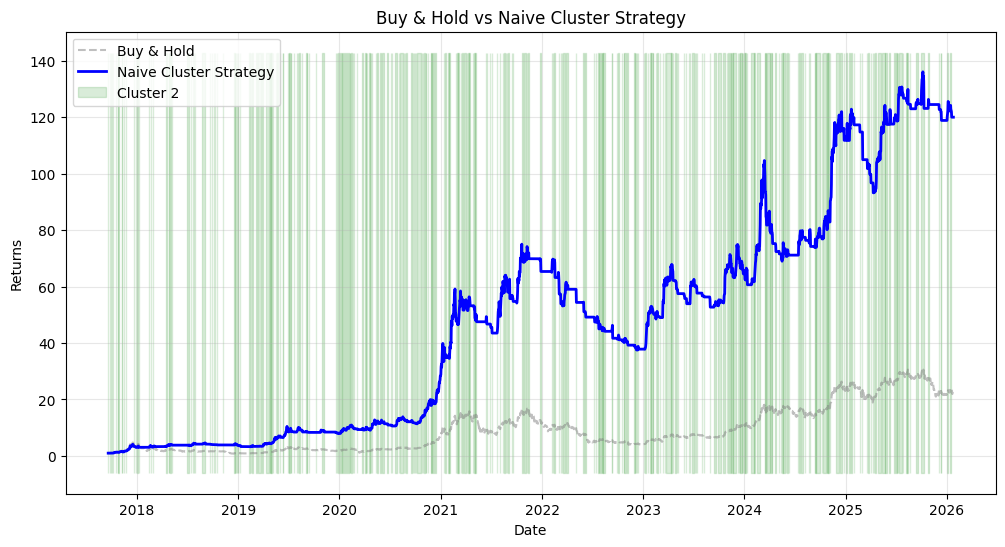

Total Returns Buy & Hold: 2114.81%
Total Returns Naive Cluster Strategy: 11900.21%


In [48]:
df['Returns'] = df['Close'].pct_change()

df['BH_Returns'] = df['Returns'].fillna(0)
df['BH_Cumulative'] = (1 + df['BH_Returns']).cumprod()

is_target_cluster = (df['cluster'] >= 2)

df['Signal'] = is_target_cluster.shift(1).fillna(0).astype(int)

df['Strategy_Returns'] = df['Returns'] * df['Signal']
df['Strategy_Cumulative'] = (1 + df['Strategy_Returns']).cumprod()

plt.figure(figsize=(12, 6))

plt.plot(df.index, df['BH_Cumulative'], label='Buy & Hold', color='gray', alpha=0.5, linestyle='--')

plt.plot(df.index, df['Strategy_Cumulative'], label='Naive Cluster Strategy', color='blue', linewidth=2)

y_min, y_max = plt.ylim()
plt.fill_between(df.index, y_min, y_max, where=(df['cluster'] == 2), 
                 color='green', alpha=0.15, label='Cluster 2')

plt.title('Buy & Hold vs Naive Cluster Strategy')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

total_return_bh = (df['BH_Cumulative'].iloc[-1] - 1) * 100
total_return_strat = (df['Strategy_Cumulative'].iloc[-1] - 1) * 100

print(f"Total Returns Buy & Hold: {total_return_bh:.2f}%")
print(f"Total Returns Naive Cluster Strategy: {total_return_strat:.2f}%")